In [57]:
import Pkg
Pkg.activate("../../");

  Activating project at `C:\SY\MIT\UROP\InverseGraphics\InverseGraphics`


In [72]:
import Revise
import GLRenderer as GL
import Images as I
import MiniGSG as S
import Rotations as R
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN
import InverseGraphics as T
import NearestNeighbors
import LightGraphs as LG
import StaticArrays
import ProgressMeter
import GenDirectionalStats as GDS
import Serialization
using Distributions
import Gen
using Plots
using ProgressMeter
try
    import MeshCatViz as V
catch
    import MeshCatViz as V    
end

In [4]:
# # Initialize the renderer
V.setup_visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8718
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


Process(`cmd.exe /C 'start http://127.0.0.1:8718'`, ProcessExited(0))

## Data loading / Camera setup

In [73]:
# Loading the YCB object models
# YCB_DIR = joinpath(dirname(dirname(pwd())),"data")
# world_scaling_factor = 10.0
# id_to_cloud, id_to_shift, id_to_box  = T.load_ycbv_models_adjusted(YCB_DIR, world_scaling_factor);
# all_ids = sort(collect(keys(id_to_cloud)));
# names = T.load_ycb_model_list(YCB_DIR)

mesh_names = ["cube_triangulated.obj",
              "sphere_triangulated.obj",
              "cylinder_small_triangulated.obj",
              "triangular_prism_triangulated.obj",
              "crescent_triangulated.obj",
             ]
all_ids = collect(1:length(mesh_names))


5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [128]:
# # Initialize the canera intrinsics and renderer that will render using those intrinsics.
# camera = GL.CameraIntrinsics()
# camera = T.scale_down_camera(camera, 5.5)

# renderer = GL.setup_renderer(camera, GL.DepthMode())
# resolution = 0.05

# @show camera;


V.setup_visualizer()
camera_intrinsics = T.GL.CameraIntrinsics(
	640, 480,
	507.8159715323307,
	508.9675493512412,
	307.0591715498334,
	231.8315010235393,
	0.01,
	10000.0
)

renderer = GL.setup_renderer(camera_intrinsics, GL.RGBMode())#GL.DepthMode())

# Reset the intrinsics inside of the renderer.
GL.set_intrinsics!(renderer, camera_intrinsics) 

gl_version_for_shaders = "460"
true
true


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8768
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


In [129]:

# # Load a cube (id = 1) and all ycb objects
# # box_mesh = GL.box_mesh_from_dims([2.0, 2.0, 2.0])
# # GL.load_object!(renderer, box_mesh)

# for id in all_ids
#     cloud = id_to_cloud[id]
#     mesh = GL.mesh_from_voxelized_cloud(GL.voxelize(cloud, resolution), resolution);
#     GL.load_object!(renderer, mesh)
# end

# @show length(all_ids)

mesh_names = ["cube_triangulated.obj",
              "sphere_triangulated.obj",
              "cylinder_small_triangulated.obj",
              "triangular_prism_triangulated.obj",
              "crescent_triangulated.obj",
             ]
all_ids = collect(1:length(mesh_names))

meshdir = joinpath(dirname(dirname(pathof(T))),"notebooks/coarse_to_fine/shape_models");
meshes = [
    T.GL.get_mesh_data_from_obj_file(joinpath(meshdir, m))
    for m in mesh_names
];


Excessive output truncated after 1044908 bytes.

mesh = GeometryBasics.TriangleP{3, Float32, GeometryBasics.PointMeta{3, Float32, GeometryBasics.Point{3, Float32}, (:uv, :normals), Tuple{GeometryBasics.Vec{2, Float32}, GeometryBasics.Vec{3, Float32}}}}[Triangle(Float32[-5.8, 6.0, -5.9], Float32[5.8, 6.0, 5.9], Float32[5.8, 6.0, -5.9]), Triangle(Float32[5.8, 6.0, 5.9], Float32[-5.8, -6.0, 5.9], Float32[5.8, -6.0, 5.9]), Triangle(Float32[-5.8, 6.0, 5.9], Float32[-5.8, -6.0, -5.9], Float32[-5.8, -6.0, 5.9]), Triangle(Float32[5.8, -6.0, -5.9], Float32[-5.8, -6.0, 5.9], Float32[-5.8, -6.0, -5.9]), Triangle(Float32[5.8, 6.0, -5.9], Float32[5.8, -6.0, 5.9], Float32[5.8, -6.0, -5.9]), Triangle(Float32[-5.8, 6.0, -5.9], Float32[5.8, -6.0, -5.9], Float32[-5.8, -6.0, -5.9]), Triangle(Float32[-5.8, 6.0, -5.9], Float32[-5.8, 6.0, 5.9], Float32[5.8, 6.0, 5.9]), Triangle(Float32[5.8, 6.0, 5.9], Float32[-5.8, 6.0, 5.9], Float32[-5.8, -6.0, 5.9]), Triangle(Float32[-5.8, 6.0, 5.9], Float32[-5.8, 6.0, -5.9], Float32[-5.8, -6.0, -5.9]), Triangle(Float32

In [130]:
# load meshes into renderer
for id in all_ids
    GL.load_object!(renderer, meshes[id])
end



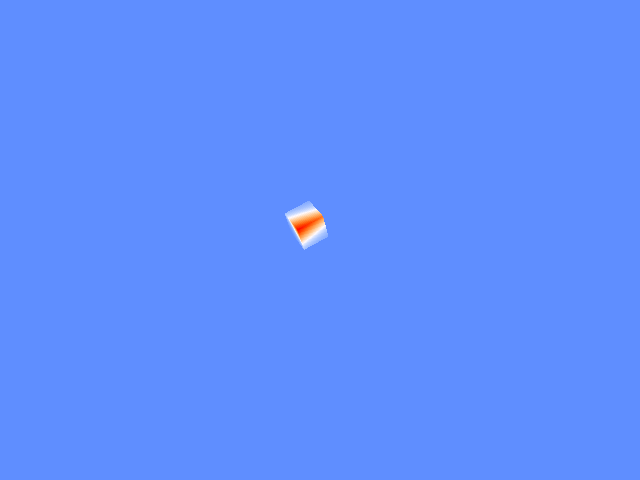

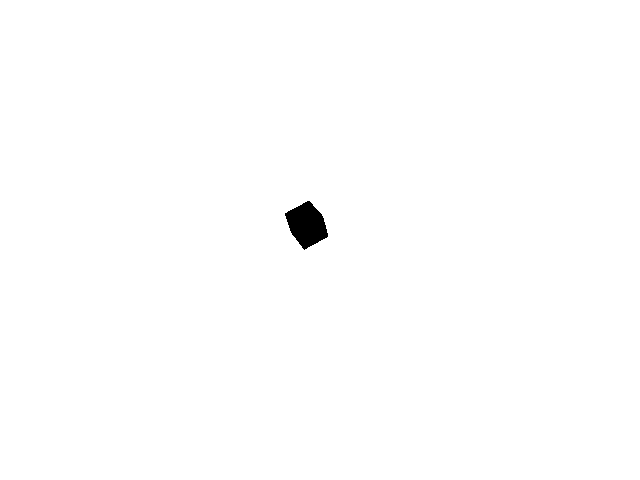

LoadError: MethodError: no method matching depth_image_to_point_cloud(::Tuple{Array{Float32, 3}, Matrix{Float64}}, ::GLRenderer.CameraIntrinsics)
[0mClosest candidates are:
[0m  depth_image_to_point_cloud([91m::Matrix[39m, ::GLRenderer.CameraIntrinsics; stride_x, stride_y, flatten, cut_far_plane) at C:\Users\karen\.julia\packages\GLRenderer\TkAsH\src\point_cloud.jl:1

In [133]:
# visualize an object

bounds = (-100.0, 100.0, -100.0, 100.0, 0.0, 200.0)

i = 1
pose = Pose([0.0, 0.0, 3.0], R.RotXYZ(0.4, -0.2, 0.4))

# ex) render img at identity pose
rgb, gt_depth_image = GL.gl_render(renderer, [i], [pose], cam_pose)
IJulia.display(GL.view_depth_image(gt_depth_image))
IJulia.display(GL.view_rgb_image(rgb))


# Create point cloud corresponding to that rendered depth image.
gt_cloud = GL.depth_image_to_point_cloud(gt_depth_image, camera_intrinsics)
# print(size(gt_cloud))

gt_cloud2 = get_cloud_nocache([pose], [i])

@show mesh_names[i]

radius = 0.01  # "tight" radius
sampled_cloud = T.voxelize(gt_cloud2, 1e-20)
# Visualize that point cloud.
# V.setup_visualizer()
V.viz(gt_cloud ./ 10, color=I.colorant"red", channel_name=:new)  


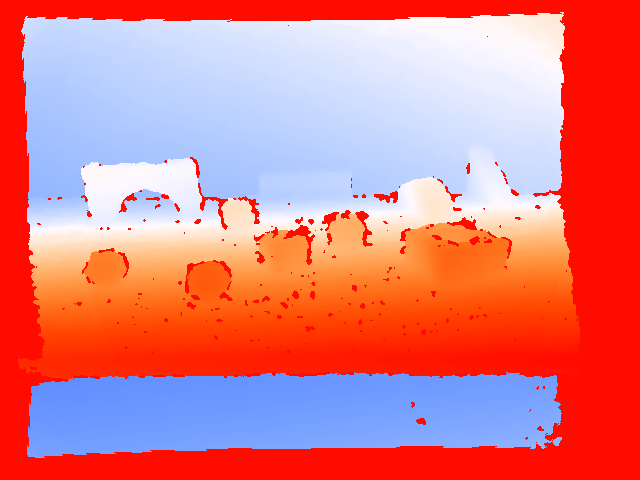

In [10]:
# load a test image (+ corresponding depth img)

data_path = joinpath(dirname(dirname(pathof(T))),"notebooks/coarse_to_fine/ibm_data")
IDX = 476
rgb_image = T.load_rgb(joinpath(data_path, "color_$(lpad(IDX,4,"0")).png"));

d = T.load_depth(joinpath(data_path, "depth_$(lpad(IDX,4,"0")).png"));
d = d ./ 5.0;

IJulia.display(GL.view_depth_image((d)))


In [11]:
# filter background / faraway 
c = T.GL.depth_image_to_point_cloud(d, camera_intrinsics);
c = c[:,c[3,:] .> 1e-4]
c = c[:, c[3,:] .< 200.1]

best_eq, sub_cloud, _ = T.find_plane(c;threshold=0.01);
cam_pose = T.camera_pose_from_table_eq(best_eq);
c = T.move_points_to_frame_b(c, cam_pose);
c = c[:, c[3,:] .> 1.0]


3×10038 Matrix{Float64}:
 -75.5554   -75.5792   -75.6031   -75.784    …   60.7315   60.7084   60.8625
 -39.7654   -39.8844   -40.0034   -39.7503      -51.6015  -51.7167  -51.4764
   7.99456    7.69184    7.38912    6.91717      11.2037   10.9109   10.4519

In [12]:
## These are the clouds of entities to infer

assign =T.dbscan_cluster(c; radius=1.0, min_cluster_size=50);
entities = T.get_entities_from_assignment(c, assign)
@show length(entities)
# ENTITIES )left to right: 
# 1 = sphere
# 2 = sphere
# 3 = cube
# 4 = cube
# 5 = rect prism with hole in middle

length(entities) = 5


5

In [123]:
# V.open_window()
V.setup_visualizer()
e = T.voxelize(entities[4], 0.00005)
V.viz(c ./ 10;channel_name=:c, color=T.I.colorant"red")  # whole scene
V.viz(entities[4] ./ 10;channel_name=:e, color=T.I.colorant"blue")   # entity

# check position stuff; put some random obj at the spot of `e` (of same size)
# centroid = T.centroid(e)
# @show p_ = Pose(centroid...)

# newcloud = T.voxelize(get_cloud_nocache([p_], [1]), 0.00005)
# V.viz(newcloud ./ 10, color=I.colorant"green", channel_name=:centroid) 


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8758
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


MeshCat Visualizer with path /meshcat/e at http://127.0.0.1:8758

# Demo: object pose estimation

### Cloud visualization / generation helpers

In [14]:
function viz_trace(trace)
    V.setup_visualizer()
    V.viz(Gen.get_retval(trace).voxelized_cloud  ./ 10.0; color=I.colorant"red", channel_name=:gen);
    V.viz(Gen.get_retval(trace).obs_cloud ./ 10.0; color=I.colorant"blue", channel_name=:obs);
end

viz_trace (generic function with 1 method)

In [52]:
# hacky viz for multiple objs
function viz_trace2(trace, channel1::Symbol, channel2::Symbol)
    V.viz(Gen.get_retval(trace).voxelized_cloud  ./ 10.0; color=I.colorant"red", channel_name=channel1);
    V.viz(Gen.get_retval(trace).obs_cloud ./ 10.0; color=I.colorant"blue", channel_name=channel2);
end


viz_trace2 (generic function with 4 methods)

In [15]:
# Helper function to get point cloud from the object ids, object poses, and camera pose
# (see demo.jl)
function get_cloud_nocache(poses, ids)
    depth_image = GL.gl_render(renderer, ids, poses, cam_pose)
    cloud = GL.depth_image_to_point_cloud(depth_image, renderer.camera_intrinsics)
    if isnothing(cloud)
        cloud = zeros(3,1)
    else
        cloud = T.move_points_to_frame_b(cloud, cam_pose)
    end
    cloud
end

get_cloud_nocache (generic function with 1 method)

### Model helpers

In [16]:
function icp_move_no_unexplained(trace, i, inf_radius, renderer, cam_pose; iterations=10)
    # get_cloud_func needs to give the points in the world frame
    get_cloud_func = (poses, ids, cam_pose) -> get_cloud_nocache([poses], [ids])  
#     get_cloud_func = (pose, id, cam_pose) -> get_cloud_func_cached(pose, id);

    id = Gen.get_choices(trace)[:id]  
    addr = T.floating_pose_addr(1)
    
    obs_cloud = T.move_points_to_frame_b(T.get_obs_cloud(trace), cam_pose)
    c1_tree = NearestNeighbors.KDTree(obs_cloud);

    refined_pose = trace[addr]
    
    refined_pose = T.icp_object_pose(
        refined_pose,
        obs_cloud,
        p -> T.voxelize(get_cloud_func(p, id, cam_pose), v_resolution(inf_radius)),
        c1_tree=c1_tree,
        iterations=iterations
    );

    acceptances = false
     
    for _ in 1:iterations
        trace, acc = T.pose_mixture_move(
            trace, addr, [trace[addr], refined_pose], [0.5, 0.5], 1e-2, 5000.0
        )
        acceptances = acc || acceptances
    end
    
    trace, acceptances, refined_pose
end

icp_move_no_unexplained (generic function with 1 method)

In [17]:
"""Selecting from a set of traces over all enumerated angles, generate a set of initial particles"""
Gen.@gen function generate_initial_pf_state(scored_traces, num_particles, num_candidate_objs, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    # unpack traces
    traces = (t -> t[1]).(scored_traces)
    log_weights = (t -> t[1].score).(scored_traces)# 
    
     _, norm_log_weights = Gen.normalize_weights(log_weights)    
    flush(stdout)
    
    # sample initial set of particles
    num_particles_per_obj = num_particles ÷ num_candidate_objs
    selected_traces = Vector{Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}}}(undef, num_particles_per_obj * num_candidate_objs)
    selected_log_weights = Vector{Float64}(undef, num_particles_per_obj * num_candidate_objs)
        
    stepsize = length(scored_traces) ÷ num_candidate_objs
    for i=0:num_candidate_objs-1
        for j = 1:num_particles_per_obj
            trace_idx = stepsize * i + 
                        Gen.random(Gen.categorical, 
                        exp.(Gen.normalize_weights(log_weights[stepsize*i+1:stepsize*(i+1)])[2]))   
            selected_traces[num_particles_per_obj*i+j] = traces[trace_idx]
            selected_log_weights[num_particles_per_obj*i+j] = norm_log_weights[trace_idx]
        end        
    end
     
    
    println("Initial particle state computed ($num_particles_per_obj particles per object)"); flush(stdout)

    
    # see intermediate results
    top_n = min(10, num_particles-1)
    _, norm_log_weights = Gen.normalize_weights(selected_log_weights)
    p = sortperm(norm_log_weights)[end-top_n:end]; 

    best_trace = selected_traces[argmax(norm_log_weights)];

    
    if topnprint
        println("top$top_n traces:")
        for idx in p
           println("curr_weight=", norm_log_weights[idx], " ori=", (Gen.get_retval(selected_traces[idx]).ori)[1:3], "id=", Gen.get_retval(selected_traces[idx]).id) 
        end
        flush(stdout)
    end
    
    return Gen.ParticleFilterState{U}(selected_traces, Vector{U}(undef, num_particles), selected_log_weights, 0., collect(1:num_particles))

end

generate_initial_pf_state

consider doing 20x random pose initialization+ICP moves

In [18]:
"""adapted from gen pf_step:
Perform a particle filter update, where the model arguments are adjusted, new observations are added, and the default proposal is used for new latent state.
"""
function particle_filter_step!(state::Gen.ParticleFilterState{U}, new_args::Tuple, argdiffs::Tuple,
        observations) where {U}    
    log_incremental_weights = Vector{Float64}(undef, num_particles) 
    radius::Float64 = new_args[1]
#     centroid::Vector{Float64} = new_args[end]
    
   @showprogress for i=1:num_particles
    ## do mh, drift moves, etc. tune particle before update (i.e. new likelihood)
        state.traces[i], acc, _ = icp_move_no_unexplained(state.traces[i], Gen.get_retval(state.traces[i]).id, 
                                            radius, renderer, cam_pose; iterations=15)

        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.001, 10.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 50.0) 
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.1, 100.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.5, 100.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.5, 500.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 1.0, 1000.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 1.0, 1000.0)
        
        
        # evolve the particle (with new radius involved in new_args)
        (state.new_traces[i], increment, _, discard) = Gen.update(
            state.traces[i], new_args, argdiffs, observations)
#         if !isempty(discard)
#             error("Choices were updated or deleted inside particle filter step: $discard")
#         end
        log_incremental_weights[i] = increment
        state.log_weights[i] += increment
    end
    
    # swap references
    tmp = state.traces
    state.traces = state.new_traces
    state.new_traces = tmp
    
    return log_incremental_weights
end

particle_filter_step!

In [19]:
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,300.0)

v_resolution = radius -> radius * 0.5  # distance between two points on the pointcloud 

"""sample point clouds at the given camera resolution and radius"""
Gen.@gen function model(radius, renderer, centroid, num_candidate_objs)
    
    # sample object id
    i = {:id} ~ Gen.categorical(fill(1.0/num_candidate_objs, (num_candidate_objs,)))
    
    # sample pose
    xc, yc, zc = centroid
    delta = 5.0
    p = {T.floating_pose_addr(1)} ~ T.uniformPose(xc-delta, xc+delta, yc-delta, yc+delta, zc-delta, zc+delta)
    gt_cloud = get_cloud_nocache([p], [i])    
#     gt_cloud = get_cloud_func_cached(p, i);

    voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(radius))
    obs_cloud = {T.obs_addr()} ~ T.uniform_mixture_from_template(voxelized_cloud, 0.0001, radius, bounds)
         
    (id=i, pose=p, pos=p.pos, ori=p.orientation, cloud=gt_cloud, voxelized_cloud=voxelized_cloud, rendered_clouds=[voxelized_cloud], obs_cloud=obs_cloud)

end
 

model

### control resolution with radius (fixed camera intrinsics)

In [124]:
"""Particle filter on the evolution of agent knowledge over time; resolution control with radius"""
function particle_filter(renderer, init_radius::Float64, final_radius::Float64, radius_step::Float64, scored_traces,
                        gt_obj_id::Int, centroid, num_candidate_objs::Int, num_particles::Int, num_samples::Int, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})

#     # initialize renderer and particle filter
#     GL.set_intrinsics!(renderer, camera)  
#     gt_cloud = get_cloud_nocache([gt_pose], [gt_obj_id])
# #     gt_cloud = get_cloud_func_cached(gt_pose, gt_obj_id)
#     gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))
    
    println("\ninitializing particle filter at radius $init_radius") 
    flush(stdout)
    
    
    # initialize a state of initial particles with various rotations  
#     state::Gen.ParticleFilterState{U} = generate_initial_pf_state_from_enum(scored_traces, num_particles)
    state::Gen.ParticleFilterState{U} = generate_initial_pf_state(scored_traces, num_particles, num_candidate_objs)

    
    # evolve over resolutions (modify sphere radius `r` of mixture point cloud likelihood)
    @assert(radius_step < 0.0); best_trace = Nothing
    for radius in init_radius+radius_step:radius_step:final_radius-eps()
        println("\n========Radius=$radius========"); flush(stdout)
        Gen.maybe_resample!(state, ess_threshold=num_particles/3, verbose=true)  
        
        # update pf 
        gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(radius))
        observations = Gen.choicemap(T.obs_addr() => gt_voxelized_cloud)#:id => gt_obj_id) 
        current_log_weights = particle_filter_step!(state, (radius, renderer, centroid, num_candidate_objs),   
                                                    (Gen.UnknownChange(),), observations)    
        
        # see intermediate results
        top_n = min(5, num_particles-1)
        _, norm_log_weights = Gen.normalize_weights(current_log_weights)
        p = sortperm(norm_log_weights)[end-top_n:end]; 
        
        best_trace = state.traces[argmax(norm_log_weights)];
        
        
        if topnprint
            println("top$top_n traces:")
            for idx in p
               println("weight=", norm_log_weights[idx], " ori=", (Gen.get_retval(state.traces[idx]).ori)[1:3], "  id=", Gen.get_retval(state.traces[idx]).id) 
            end
            flush(stdout)
        end
        
    end;
    
    if vis
        randomchannel1, randomchannel2 = rand(2)
        viz_trace2(best_trace, Symbol(randomchannel1), Symbol(randomchannel2));
    end
    # normalize final weights
    log_total_weight, norm_weights = Gen.normalize_weights(state.log_weights)
    return [norm_weights, Gen.sample_unweighted_traces(state, num_samples)]
    
end

particle_filter

In [21]:
unit_sphere_directions = T.fibonacci_sphere(25);
other_rotation_angle = collect(0:0.30:(2*π));
rotations_to_enumerate_over = [
    let
        T.geodesicHopf_select_axis(StaticArrays.SVector(dir...), ang, 1)
    end
    for dir in unit_sphere_directions, 
        ang in other_rotation_angle
];
# @show length(rotations_to_enumerate_over)
dirs = hcat(unit_sphere_directions...)

3×25 Matrix{Float64}:
 0.0  -0.294691   0.0483264  0.402444  …  -0.453747   0.0877163   0.0
 1.0   0.916667   0.833333   0.75         -0.833333  -0.916667   -1.0
 0.0   0.269961  -0.550654   0.524918      0.315705  -0.389908    0.0

In [40]:
function precompute_enumerations(gt_voxelized_cloud, gt_position, init_radius, renderer, num_candidate_objs, rotations_to_enumerate_over)
    # initialize a state of initial particles with various rotations
    all_scored_traces = []
    x, y, z = gt_position
    @showprogress for id=1:num_candidate_objs
#         scored_traces = map(orn -> 
#                         Gen.generate(model, (init_radius, renderer, gt_position),                 
#                                     Gen.choicemap(T.obs_addr() => gt_voxelized_cloud, 
#                                                 :id => obj_id, 
#                                                 T.floating_pose_addr(1) => Pose(gt_position, orn))),
#                                     rotations_to_enumerate_over[:]);
        scored_traces = map(orn -> 
                Gen.generate(model, (init_radius, renderer, gt_position),                 
                            Gen.choicemap(T.obs_addr() => gt_voxelized_cloud, 
                                        :id => id, 
                                        T.floating_pose_addr(1) => Pose(gt_position, orn))),
                            rotations_to_enumerate_over[:]);
    
        all_scored_traces = vcat(all_scored_traces, scored_traces)
    end
    return all_scored_traces
    
end  

function precompute_enumerations_icp(gt_voxelized_cloud, gt_position, init_radius, renderer, num_candidate_objs)
#     pose_hypotheses = []
#     latent_clouds = []
#     likelihood_scores = []
#     ids = []
    c1_tree = NearestNeighbors.KDTree(gt_voxelized_cloud);

    function sample_and_refine(id, init_pose)
        # Run ICP to refine that initial pose. (Use the KDTree to accelerate this.)
        refined_pose = T.icp_object_pose(
                init_pose, 
                gt_voxelized_cloud,
                p ->  get_cloud_nocache([p], [id]);
                c1_tree=c1_tree,
                outer_iterations=4,
                iterations=5
        );
        tr, _ = Gen.generate(model, (init_radius, renderer, gt_position, num_candidate_objs),                 
                    Gen.choicemap(T.obs_addr() => gt_voxelized_cloud, 
                                :id => id, 
                                T.floating_pose_addr(1) => refined_pose))
        tr_score = Gen.logpdf(
                T.uniform_mixture_from_template,
                gt_voxelized_cloud,
                get_cloud_nocache([refined_pose], [id]),
                0.05,
                0.01,
                (-100.0,100.0,-100.0,100.0,-100.0,300.0)
        )
        tr.score = tr_score
        
        return tr, tr_score    
    end
    
    all_scored_traces = []
    @showprogress for id=1:num_candidate_objs
        for i=1:10
            scored_traces = sample_and_refine(id, Pose(centroid, GDS.uniform_rot3()))    
            all_scored_traces = vcat(all_scored_traces, scored_traces)
        end
    end
    return all_scored_traces  
end

precompute_enumerations_icp (generic function with 1 method)

In [54]:
final_radius = float(0.6)  # low to high "focus"
init_radius = float(1.5)  # high num = faster enum

num_particles_per_obj = 2
num_candidate_objs = 3#length(mesh_names)
num_particles = num_particles_per_obj * num_candidate_objs
@show num_samples = num_particles
num_steps = 1
radius_step = (final_radius - init_radius)/num_steps

topnprint, vis = true, true  # print top particles / meshcat viz



num_samples = num_particles = 6


(true, true)

### single object trial

In [105]:
# mesh_names = ["cube_triangulated.obj",
#               "sphere_triangulated.obj",
#               "cylinder_small_triangulated.obj",
#               "triangular_prism_triangulated.obj",
#               "crescent_triangulated.obj",
#              ]
# ENTITIES )left to right: 
# 1 = sphere
# 2 = sphere
# 3 = cube
# 4 = cube
# 5 = rect prism with hole in middle

predicted_scene = Dict()
V.setup_visualizer()
for (ii, jj) in [(2, 1), (2, 2), (1, 3), (1, 4)]
    gt_obj_id, gt_cloud = ii, entities[jj]   # (2, 1), (2, 2), (1, 3), (1, 4), (?, 5)
    @show object = mesh_names[gt_obj_id]

    gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))
    # V.setup_visualizer()
    # V.viz(gt_voxelized_cloud ./ 10)

    # get centroid (at a finer resolution)
    @show centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1e-10)))

    @time enum_ori_traces = precompute_enumerations_icp(gt_voxelized_cloud, centroid, init_radius, renderer, 
        num_candidate_objs);

    @time weights, pf_traces = particle_filter(renderer, init_radius, final_radius, radius_step,
                                    enum_ori_traces, gt_obj_id, centroid, num_candidate_objs, num_particles, num_samples);
    
    predicted_scene[jj] = pf_traces[argmax(weights)]  # save best trace
end



┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8746
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


object = mesh_names[gt_obj_id] = "sphere_triangulated.obj"
centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1.0e-10))) = [-68.67828108193599, -39.79812584676757, 7.565887590904762]
 10.642866 seconds (2.24 M allocations: 7.818 GiB, 17.59% gc time)

initializing particle filter at radius 1.5
Initial particle state computed (2 particles per object)
top5 traces:
curr_weight=-1.791759469228055 ori=[0.9125221647725824, -0.2528277050037286, -0.3215298592375306]id=1
curr_weight=-1.791759469228055 ori=[-0.3690654471237675, 0.4663491073190736, 0.8039335829793638]id=1
curr_weight=-1.791759469228055 ori=[-0.3987836125496746, 0.6417144049149704, 0.6551139235937904]id=2
curr_weight=-1.791759469228055 ori=[0.552153313197912, -0.4254202774673594, -0.7170385667759889]id=2
curr_weight=-1.791759469228055 ori=[0.3855877637247468, 0.6663501803852052, -0.6382002143264729]id=3
curr_weight=-1.791759469228055 ori=[-0.8978937685113687, 0.3824468725578658, -0.2179935093968569]id=3

========Radius=0.6===

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


effective sample size: 6.0, doing resample: false
top5 traces:
weight=-7835.328593227159 ori=[0.9122881632685479, -0.3584846401338441, -0.19803805176835923]  id=1
weight=-6870.878452135637 ori=[-0.9485731106659936, 0.01490752376906059, -0.3162069250609747]  id=1
weight=-6245.19748383982 ori=[0.49008715659636437, 0.6106875559462196, -0.6219929967063347]  id=3
weight=-6098.245189270749 ori=[0.2261355578666351, -0.11279441669621323, -0.9675433473651236]  id=2
weight=-4415.33789404153 ori=[-0.8979349211679092, 0.3601410679682799, -0.2530045227063087]  id=3
weight=0.0 ori=[-0.43585512619346806, 0.8931435277003444, 0.11101778189937442]  id=2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  7.909526 seconds (748.84 k allocations: 6.302 GiB, 18.54% gc time)
object = mesh_names[gt_obj_id] = "sphere_triangulated.obj"
centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1.0e-10))) = [-33.64302452178544, -54.89634407826161, 7.9465414932450935]
  9.587790 seconds (2.53 M allocations: 7.858 GiB, 17.27% gc time)

initializing particle filter at radius 1.5
Initial particle state computed (2 particles per object)
top5 traces:
curr_weight=-1.791759469228055 ori=[-0.2911272884153947, 0.830173032427486, 0.47545519049648577]id=1
curr_weight=-1.791759469228055 ori=[-0.5222947850284696, -0.34903659021941436, 0.7780627328307599]id=1
curr_weight=-1.791759469228055 ori=[-0.6487544798015784, -0.49401950871439837, 0.578845704784073]id=2
curr_weight=-1.791759469228055 ori=[0.31818443895135406, 0.5302397863676802, 0.7858781278047952]id=2
curr_weight=-1.791759469228055 ori=[0.14912574177336832, 0.5363158641448995, -0.8307387116338377]id=3
curr_weight=-1.791759469228055 ori=[0.1491257417733

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


effective sample size: 6.0, doing resample: false
top5 traces:
weight=-7865.1802678487875 ori=[-0.6056878272405664, -0.4833297573586342, 0.6320874951968654]  id=1
weight=-7422.461428849458 ori=[0.08410940606584465, 0.7764872521298475, 0.624494319502657]  id=1
weight=-3628.7200264400726 ori=[0.1621375917997903, 0.5153894709316318, -0.8414779228109157]  id=3
weight=-3257.444067898361 ori=[0.1042554570458101, 0.4821001090683339, -0.8698909612775994]  id=3
weight=-354.2816497454223 ori=[0.20209242407588446, 0.7645506246588821, 0.6120629007421119]  id=2
weight=0.0 ori=[-0.6065325298990136, -0.2298432138021575, 0.7611112844015651]  id=2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  8.276442 seconds (780.21 k allocations: 6.307 GiB, 18.25% gc time)
object = mesh_names[gt_obj_id] = "cube_triangulated.obj"
centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1.0e-10))) = [-10.153006743115485, -35.70291998347662, 7.326533120299944]
  9.554947 seconds (2.00 M allocations: 7.783 GiB, 17.52% gc time)

initializing particle filter at radius 1.5
Initial particle state computed (2 particles per object)
top5 traces:
curr_weight=-1.791759469228055 ori=[0.3463026048186974, -0.9313681282802349, -0.11237399841402952]id=1
curr_weight=-1.791759469228055 ori=[0.8952200759818542, 0.4384195385908464, 0.07980804308359153]id=1
curr_weight=-1.791759469228055 ori=[0.668815727735729, -0.7431808254512318, 0.019177669695547038]id=2
curr_weight=-1.791759469228055 ori=[-0.04553720608908758, 0.770929995923901, 0.6352899371518297]id=2
curr_weight=-1.791759469228055 ori=[-0.631748300040241, -0.4590899572762512, 0.6246042719389253]id=3
curr_weight=-1.791759469228055 ori=[-0.105888446519718

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


effective sample size: 6.0, doing resample: false
top5 traces:
weight=-12077.594047727402 ori=[-0.1156007494397604, 0.9594805311878745, 0.2569699924123482]  id=2
weight=-11968.601462117076 ori=[0.6703680166541423, -0.7408137367131715, -0.042446787207722686]  id=2
weight=-8181.851585188098 ori=[-0.05971646466051291, -0.9980696036640955, -0.01705901785681897]  id=3
weight=-8096.606674640592 ori=[-0.6488268810058605, -0.39385459670808404, 0.651077748917992]  id=3
weight=-3660.094419237703 ori=[0.3778737386698914, -0.9236482305308359, -0.06391700760278052]  id=1
weight=0.0 ori=[0.9005597671773604, 0.434639719397924, -0.008967723409656994]  id=1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  8.166915 seconds (702.37 k allocations: 6.296 GiB, 18.57% gc time)
object = mesh_names[gt_obj_id] = "cube_triangulated.obj"
centroid = T.centroid(GL.voxelize(gt_cloud, v_resolution(1.0e-10))) = [13.43116204742328, -22.119554456378808, 7.139353152772268]
  9.560514 seconds (1.68 M allocations: 7.735 GiB, 16.68% gc time)

initializing particle filter at radius 1.5
Initial particle state computed (2 particles per object)
top5 traces:
curr_weight=-1.791759469228055 ori=[0.814518683706415, 0.5742246484153382, 0.08261577963955481]id=1
curr_weight=-1.791759469228055 ori=[-0.304842302094998, 0.18781425971837978, -0.9337006879615397]id=1
curr_weight=-1.791759469228055 ori=[0.8007608391514037, 0.46586237885503085, 0.3765027522463479]id=2
curr_weight=-1.791759469228055 ori=[-0.37220977657103854, 0.9153699198187094, -0.15348547851840144]id=2
curr_weight=-1.791759469228055 ori=[-0.1018994409156189, -0.9946792118861163, -0.01515814575403036]id=3
curr_weight=-1.791759469228055 ori=[-0.1018994409156

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


effective sample size: 6.0, doing resample: false
top5 traces:
weight=-1387.3107773808515 ori=[0.036158532813291594, -0.9951600019701246, 0.09137357924265686]  id=3
weight=-1118.4992903523525 ori=[-0.17490236737416134, 0.9098649577481746, -0.376237851031527]  id=2
weight=-1102.0684280969745 ori=[0.7736832729312388, 0.6202693033326898, 0.12915178872005278]  id=1
weight=-656.938355781349 ori=[0.8062541016019402, 0.4456712399831164, 0.3890134567106427]  id=2
weight=-232.0135890315596 ori=[-0.003838555990274614, -0.9935191537243829, -0.11359998534638116]  id=3
weight=0.0 ori=[-0.37129085611023266, 0.16400789330788382, -0.9139171248541267]  id=1
  7.917232 seconds (636.09 k allocations: 6.285 GiB, 17.96% gc time)


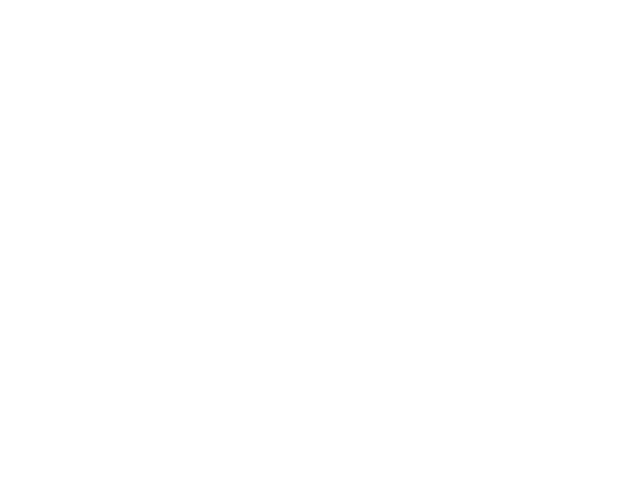

3×1307 Matrix{Float64}:
  -8.80678   -8.78506   -8.81768  …    8.39145    8.41235    8.42284
  -7.47135   -7.04636   -6.66446       1.093      1.50634    1.91935
 207.439    206.928    207.696       208.471    208.99     209.251

In [144]:
# visualize an object

channel_names = [:sphere1, :sphere2, :sphere3, :sphere4]
gt_channel_names = [:gtsphere1, :gtsphere2, :gtsphere3, :gtsphere4]

# rgb, gt_depth_image = GL.gl_render(renderer, [i], [pose], cam_pose)
# IJulia.display(GL.view_depth_image(gt_depth_image))
# IJulia.display(GL.view_rgb_image(rgb))


# V.setup_visualizer()
rgb_pred = Nothing
# for object=1:4
    gt_cloud = GL.depth_image_to_point_cloud(gt_depth_image, camera_intrinsics)
    rgb_pred, depth_pred = GL.gl_render(renderer, [Gen.get_retval(predicted_scene[object]).id for object in 1:4], 
                                            [Gen.get_retval(predicted_scene[object]).pose for object in 1:4], cam_pose,
                                                colors=[I.colorant"red" for object=1:4])

#     rgb_pred, depth_pred = GL.gl_render(renderer, [Gen.get_retval(predicted_scene[object]).id for object in 1:4], 
#                                             [Gen.get_retval(predicted_scene[object]).pose for object in 1:4], cam_pose)
    
    IJulia.display(GL.view_rgb_image(rgb_pred))
    pred_cloud = GL.depth_image_to_point_cloud(gt_depth_image, camera_intrinsics)
#     V.viz(entities[4], color=I.colorant"blue", channel_name=gt_channel_names[object])  
#     V.viz(gt_cloud ./ 10, color=I.colorant"red", channel_name=channel_names[object])  
# end

In [106]:
Gen.get_retval(predicted_scene[1]).pose

Pose⟨pos=[-69.3015968171328, -36.42192462283158, 6.715346141626198], orientation=(w=0.3607136142723325, x=-0.38981806702852556, y=-0.6881372621277094, z=0.49436289461094746)⟩